In [42]:
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

In [44]:
# Loads game and recommendation data
games_df = pd.read_csv('games.csv')
recommendation_df = pd.read_csv('recommendations.csv', nrows=500000)

In [46]:
# Merge the two dataframes by 'app_id' to keep only the games that are in both datasets
merged_df = pd.merge(recommendation_df, games_df, on='app_id', how='inner')

In [96]:
""" 6. AFTER EXPLAINING ABOUT SIMILAITY, YOU CAN SHOW THE IMAGE OF NETWORK OF TOP 10 GAMES THAT OWN BY MOST USERS

UNCOMMENT THIS IF YOU NEED TO EXPORT TO GRAPHML FILE  #nx.write_graphml(G, 'game_network.graphml')

SyntaxError: incomplete input (4145020189.py, line 1)

In [80]:
# Initialize an empty graph for games (games as nodes)
G = nx.Graph()

# Create a dictionary to store the users that recommended each game
game_users = {}

# Populate the dictionary with user data for each game
for _, row in merged_df.iterrows():
    app_id = row['app_id']
    user_id = row['user_id']
    if app_id not in game_users:
        game_users[app_id] = set()
    game_users[app_id].add(user_id)

# Add nodes to the graph
G.add_nodes_from(game_users.keys())

# Create edges between games that share common users
for game1 in game_users:
    for game2 in game_users:
        if game1 != game2:  # Skip self-loops
            common_users = game_users[game1].intersection(game_users[game2])
            if common_users:  # If there are common users
                G.add_edge(game1, game2, weight=len(common_users))

# Find the game with the most connections (highest degree)
game_degrees = dict(G.degree())

# Sort games by degree in descending order and get the top 10
top_10_games = sorted(game_degrees.items(), key=lambda x: x[1], reverse=True)[:10]

# Find the names of the top 10 games
top_10_games_with_names = [
    (games_df[games_df['app_id'] == app_id]['title'].values[0], app_id, degree)
    for app_id, degree in top_10_games
]

# Print the results
print("Top 10 Games with that own by users:")
for rank, (name, app_id, degree) in enumerate(top_10_games_with_names, start=1):
    print(f"{rank}. {name} (app_id: {app_id}) - {degree} connections")

#nx.write_graphml(G, 'game_network.graphml')


Top 10 Games with that own by users:
1. No Man's Sky (app_id: 275850) - 174 connections
2. Fallout 4 (app_id: 377160) - 174 connections
3. Cyberpunk 2077 (app_id: 1091500) - 171 connections
4. Grand Theft Auto V (app_id: 271590) - 168 connections
5. Red Dead Redemption 2 (app_id: 1174180) - 164 connections
6. Sea of Thieves 2023 Edition (app_id: 1172620) - 162 connections
7. Call of Duty® (app_id: 1938090) - 161 connections
8. Wallpaper Engine (app_id: 431960) - 159 connections
9. Rust (app_id: 252490) - 158 connections
10. DARK SOULS™ III (app_id: 374320) - 155 connections


In [50]:
#FIND THE SIMILARITY

In [76]:
# Select relevant fields for comparison
games = games_df[['app_id', 'title', 'rating', 'positive_ratio']]
rec = recommendation_df[['app_id', 'hours']]

# Merge datasets on 'app_id'
df = pd.merge(games, rec, on='app_id')

In [54]:
# Define the fields for comparison
fields = ['positive_ratio', 'hours']

# Convert columns to numeric and converting invalid data to NaN
for col in fields: 
    df[col] = pd.to_numeric(df[col], errors='coerce')
    
# Drop rows with missing values
df = df.dropna(subset=fields)
df.reset_index(inplace=True, drop=True)

In [ ]:
""" 5. NOW AFTER, HAVING THE MONTH, 
THEN WHICH GAME TO RECOMMEND? JUST THOSE 3 WOULD NOT BE ENOUGH, WE WILL USE EUCLIDEAN TO FIND SIMILARITY FROM THOSE 3 GAMES
THEN RECOMEND ABOUT 10 GAMES THAT RELATE TO THOSE 3 GAMES

In [56]:
titles = df[['title']].values.tolist()

target_title = "Call of Duty®"
target_game_index = df[df['title'] == target_title].index[0]
target_game = df.loc[target_game_index, fields].astype(float)


In [58]:
# Calculate distances for positive_ratio
positive_ratio_distances = euclidean_distances(df[['positive_ratio']], [target_game[0:1]])[:, 0]
positive_ratio_query_distances = list(zip(df.index, positive_ratio_distances))

# Calculate distances for hours played
hours_distances = euclidean_distances(df[['hours']], [target_game[1:2]])[:, 0]
hours_query_distances = list(zip(df.index, hours_distances))

In [60]:
# Check for unique names (no duplicate titles)
unique_games_set = set()

# Print most similar games by positive ratio
print("\nMost Similar Games by Positive Ratio:")
for index, distance in sorted(positive_ratio_query_distances, key=lambda x: x[1]):
    if titles[index][0] not in unique_games_set:
        print(f"{titles[index][0]} - Distance: {distance}")
        unique_games_set.add(titles[index][0])
    if len(unique_games_set) >= 10:
        break # Print top 10 unique games
        
# clear for next use
unique_games_set.clear()

# Print most similar games by hours played
print("\nMost Similar Games by Hours Played:")
for index, distance in sorted(hours_query_distances, key=lambda x: x[1])[:10]:
    print(f"{titles[index][0]} - Distance: {distance}")


Most Similar Games by Positive Ratio:
Call of Duty® - Distance: 0.0
PUBG: BATTLEGROUNDS - Distance: 2.0
The Callisto Protocol™ - Distance: 3.0
Total War: WARHAMMER III - Distance: 3.0
War Robots - Distance: 3.0
Need for Speed™ Unbound - Distance: 3.0
Warhammer 40000: Darktide - Distance: 4.0
EA SPORTS™ FIFA 23 - Distance: 5.0
NBA 2K23 - Distance: 5.0
Victoria 3 - Distance: 7.0

Most Similar Games by Hours Played:
House Flipper - Distance: 0.0
House Flipper - Distance: 0.0
Nioh 2 – The Complete Edition - Distance: 0.0
The Forest - Distance: 0.0
The Forest - Distance: 0.0
Cities: Skylines - Distance: 0.0
Total War: WARHAMMER III - Distance: 0.0
Total War: WARHAMMER III - Distance: 0.0
Fallout 76 - Distance: 0.0
Fallout 76 - Distance: 0.0


In [90]:
# Checking a different game
target_title = "Stray"
target_game_index = df[df['title'] == target_title].index[0]
target_game = df.loc[target_game_index, fields].astype(float)

# Calculate distances for positive_ratio
positive_ratio_distances = euclidean_distances(df[['positive_ratio']], [target_game[0:1]])[:, 0]
positive_ratio_query_distances = list(zip(df.index, positive_ratio_distances))

unique_games_set.clear()

print("\nMost Similar Games by Positive Ratio:")
for index, distance in sorted(positive_ratio_query_distances, key=lambda x: x[1]):
    if titles[index][0] not in unique_games_set:
        print(f"{titles[index][0]} - Distance: {distance}")
        unique_games_set.add(titles[index][0])
    if len(unique_games_set) >= 10:
        break # Print top 10 unique games



Most Similar Games by Positive Ratio:
Persona 5 Royal - Distance: 0.0
Left 4 Dead 2 - Distance: 0.0
Terraria - Distance: 0.0
Stray - Distance: 0.0
Deep Rock Galactic - Distance: 0.0
Hollow Knight - Distance: 0.0
PowerWash Simulator - Distance: 0.0
Bloons TD 6 - Distance: 0.0
Euro Truck Simulator 2 - Distance: 0.0
Papers Please - Distance: 0.0


In [92]:
# Checking a different game
target_title = "Cyberpunk 2077"
target_game_index = df[df['title'] == target_title].index[0]
target_game = df.loc[target_game_index, fields].astype(float)

# Calculate distances for positive_ratio
positive_ratio_distances = euclidean_distances(df[['positive_ratio']], [target_game[0:1]])[:, 0]
positive_ratio_query_distances = list(zip(df.index, positive_ratio_distances))

unique_games_set.clear()

print("\nMost Similar Games by Positive Ratio:")
for index, distance in sorted(positive_ratio_query_distances, key=lambda x: x[1]):
    if titles[index][0] not in unique_games_set:
        print(f"{titles[index][0]} - Distance: {distance}")
        unique_games_set.add(titles[index][0])
    if len(unique_games_set) >= 10:
        break # Print top 10 unique games


Most Similar Games by Positive Ratio:
Cyberpunk 2077 - Distance: 0.0
Apex Legends™ - Distance: 0.0
Dead by Daylight - Distance: 0.0
Ancestors: The Humankind Odyssey - Distance: 0.0
Destiny 2 - Distance: 1.0
Total War: WARHAMMER - Distance: 1.0
Anno 1800 - Distance: 1.0
Summoners War: Chronicles - Distance: 1.0
Wizard101 - Distance: 1.0
Marvel's Midnight Suns - Distance: 1.0


In [ ]:
"""1. FIRST START WITH THIS CHART AND ANALYZE WHICH MONTH DO USER TEND TO SPEND MONEY THE MOST. 

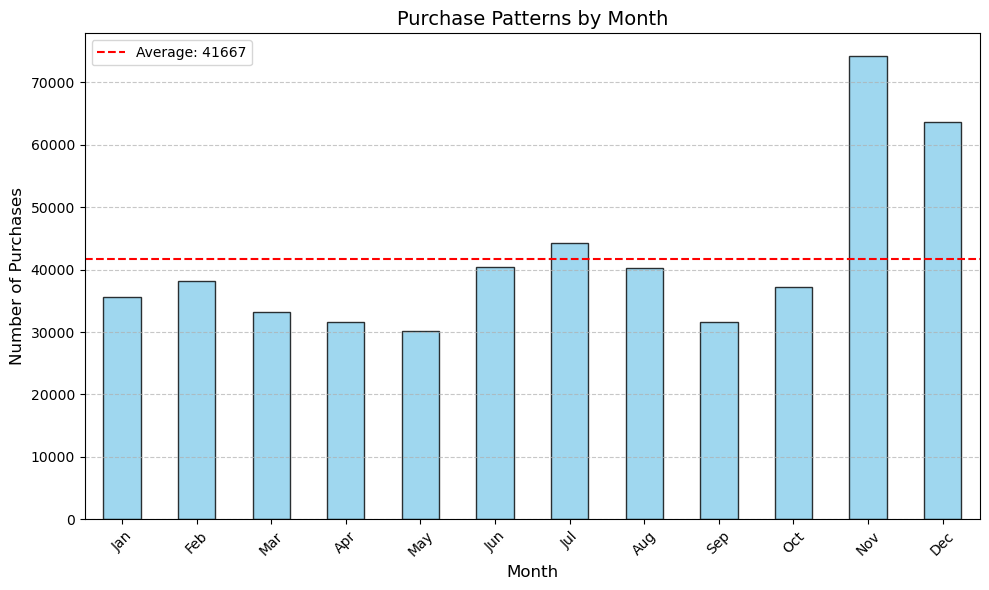

In [65]:
#THIS CHART WILL FIND THE PATTERN OF WHHICH MONTH DO PEOPLE TEND TO SPEND MONEY FOR GAMES. SEEM LIKE JUN, JUL, NOV AND DEC HAVE HIGHER 
#PURCHASE THAN THE OTHER MONTHS. REASONS COULD BE JUN, JUL ARE THE BEGGINING OF SUMMER, AND NOV, DEC HAVE 2 SALE EVENTS (BLACK FRIDAY, CHRISTMAS)
# Convert 'date' column to datetime format
recommendation_df['date'] = pd.to_datetime(recommendation_df['date'], errors='coerce')

# Extract the month from the 'date' column
recommendation_df['month'] = recommendation_df['date'].dt.month

# Aggregate the number of purchases by month
monthly_purchases = recommendation_df.groupby('month').size()

# Calculate the average number of purchases
average_purchases = monthly_purchases.mean()

# Plot the purchase pattern by month
plt.figure(figsize=(10, 6))
monthly_purchases.plot(kind='bar', color='skyblue', alpha=0.8, edgecolor='black')

# Add the average line
plt.axhline(y=average_purchases, color='red', linestyle='--', label=f'Average: {average_purchases:.0f}')

# Customize the chart
plt.title('Purchase Patterns by Month', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Purchases', fontsize=12)
plt.xticks(ticks=range(12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
], rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
""" 2. THEN, ANALYZE USE THIS CHART TO FIND THE HOURS USEER SPEND TO PLAY GAMES, IN EACH MONTH. 

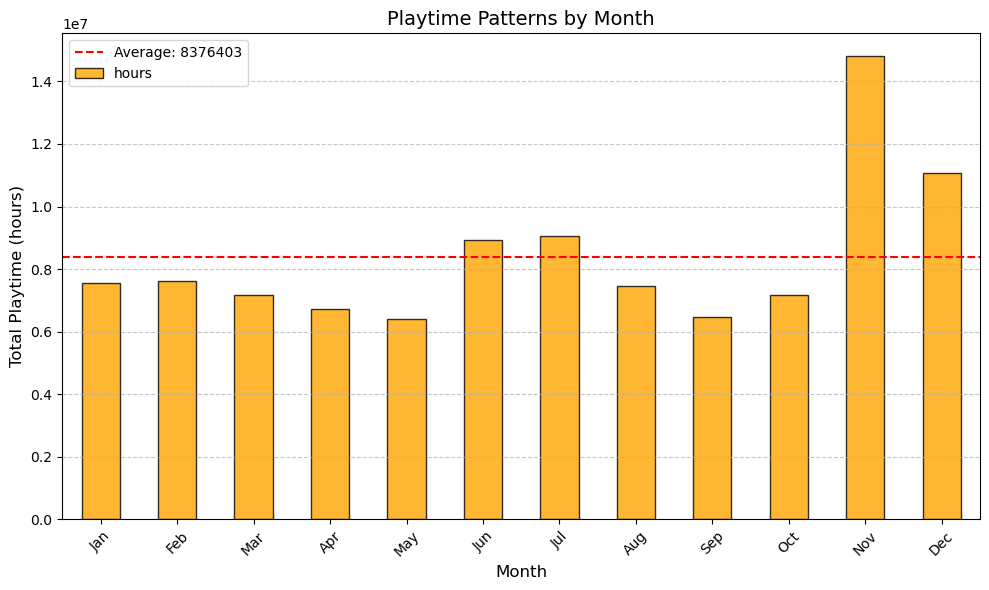

In [67]:
#JAN - MAY: THE PLAY TIME DROP EVERY MONTHS COULD BE BECAUSE MOST OF THE GAMEER ARE PEOPLE STILL IN SCHOOL, AND JAN-MAY ARE STILL IN SCHOOL TIME. 
#THIS ASSUMPTION WAS MADE BECAUSE SCHOOL MATERILA WILL GET HEAVY AT THE END, AND IT MATCH WITH THE PLAYTIME PATTERN
#THE HOURS PLAYED JUMP HIGHER WHEN JUN AND JUL, AND SLOWLY DROP IN AUG AND SEP (WHEN SCHOOL ABOUT TO START)
#BUT ON THE OTHER HAND, NOVEMBER HAS THE HIGHEST HOURS PLAYED, WHY? 
#THIS COULD BE UNDERSTAND BECAUSE NOVEMBER HAS THE BIGGEST SALE EVENT OF THE YEAR (BLACK FRIDAY), AND PEOPLE USUALLY, PLAY THE GAME THAT THEY JUST BOUGHT. 

# Convert the 'hours' column to numeric (in case there are invalid entries)
recommendation_df['hours'] = pd.to_numeric(recommendation_df['hours'], errors='coerce')

# Aggregate the total hours played by month
monthly_playtime = recommendation_df.groupby('month')['hours'].sum()

# Calculate the average playtime
average_playtime = monthly_playtime.mean()

# Plot the playtime pattern by month
plt.figure(figsize=(10, 6))
monthly_playtime.plot(kind='bar', color='orange', alpha=0.8, edgecolor='black')

# Add the average line
plt.axhline(y=average_playtime, color='red', linestyle='--', label=f'Average: {average_playtime:.0f}')

# Customize the chart
plt.title('Playtime Patterns by Month', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Playtime (hours)', fontsize=12)
plt.xticks(ticks=range(12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
], rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
"""3. AFTER THAT, COMBINE 2 CHARTS ABOOVE USING CORRELATION ANALYSIS, WE GET 3 MONTHS THAT BEST TO RECOMMEND GAME AND SALE TO USER

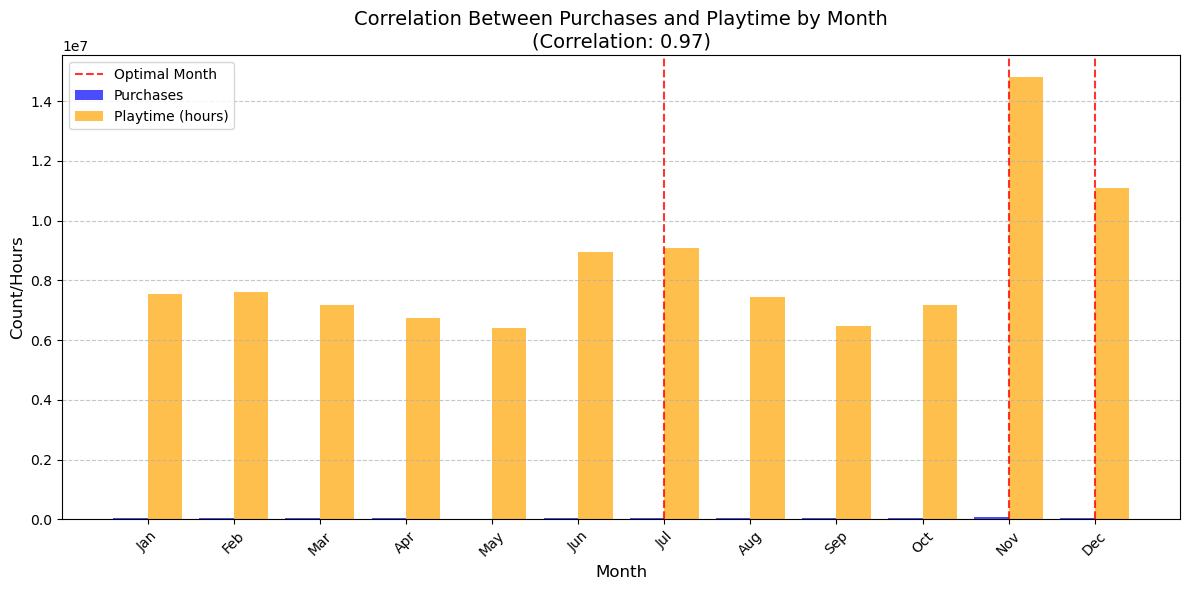

The months with both high purchases and high playtime are: 11, 12, 7.


In [69]:
# Aggregate the number of purchases (count of rows) by month
monthly_purchases = recommendation_df.groupby('month')['date'].count().reset_index()
monthly_purchases.columns = ['month', 'purchases']

# Merge the purchase data with playtime data
combined_data = pd.merge(
    monthly_purchases,
    monthly_playtime.reset_index(),
    on='month',
    how='inner'
)
combined_data.columns = ['month', 'purchases', 'total_hours']

# Calculate correlation between purchases and playtime
correlation = combined_data['purchases'].corr(combined_data['total_hours'])

# Plot combined insights
plt.figure(figsize=(12, 6))

# Bar plot for purchases
plt.bar(combined_data['month'] - 0.2, combined_data['purchases'], width=0.4, label='Purchases', color='blue', alpha=0.7)

# Bar plot for playtime
plt.bar(combined_data['month'] + 0.2, combined_data['total_hours'], width=0.4, label='Playtime (hours)', color='orange', alpha=0.7)

# Highlight peaks (months with top 3 purchases and playtime)
top_purchases_months = combined_data.nlargest(3, 'purchases')['month']
top_playtime_months = combined_data.nlargest(3, 'total_hours')['month']
overlap_months = set(top_purchases_months).intersection(top_playtime_months)

# Highlight overlapping months
for month in overlap_months:
    plt.axvline(month, color='red', linestyle='--', alpha=0.8, label='Optimal Month' if month == min(overlap_months) else None)

# Customize the chart
plt.title(f'Correlation Between Purchases and Playtime by Month\n(Correlation: {correlation:.2f})', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Count/Hours', fontsize=12)
plt.xticks(ticks=range(1, 13), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
], rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

# Print overlapping months
print(f"The months with both high purchases and high playtime are: {', '.join(map(str, overlap_months))}.")


In [ ]:
"""4. THEN, FIND WHICH GAME DO USER PLAY THE MOST IN THOSE 3 MONTHS (7, 11, 12)

In [71]:
# Convert the 'date' column to datetime format
recommendation_df['date'] = pd.to_datetime(recommendation_df['date'])

# Extract the month and year for grouping
recommendation_df['month'] = recommendation_df['date'].dt.month
recommendation_df['year'] = recommendation_df['date'].dt.year

# Filter data for July, November and December
peak_months_data = recommendation_df[recommendation_df['month'].isin([7, 11, 12])]

# Group by game (app_id) and month, and count purchases
highest_purchases = (
    peak_months_data.groupby(['app_id', 'month'])
    .size()
    .reset_index(name='purchase_count')
)

# Identify the game with the highest purchase count for each month
highest_purchases_by_month = (
    highest_purchases.loc[highest_purchases.groupby('month')['purchase_count'].idxmax()]
)

# Merge with the games dataset to get the game titles (assuming `games.csv` is the games dataset)
result = highest_purchases_by_month.merge(games_df[['app_id', 'title']], on='app_id', how='left')

# Display the results
print(result)


    app_id  month  purchase_count           title
0  1332010      7            2732           Stray
1  1938090     11            6677   Call of Duty®
2  1091500     12            4255  Cyberpunk 2077


In [ ]:
"""THIS IS JUST FOR EXTRA, IF YOU WANT TO INCLUDE IN THE ANALAYSIS, THIS IS THE TOP PURCHASE GAME BY MONTH. 

In [73]:

# Extract the month and year for grouping
recommendation_df['month'] = recommendation_df['date'].dt.month
recommendation_df['year'] = recommendation_df['date'].dt.year

# Group by game (app_id) and month, and count purchases
monthly_purchases = (
    recommendation_df.groupby(['app_id', 'month'])
    .size()
    .reset_index(name='purchase_count')
)

# Identify the game with the highest purchase count for each month
highest_purchases_by_month = (
    monthly_purchases.loc[monthly_purchases.groupby('month')['purchase_count'].idxmax()]
)

# Merge with the games dataset to get the game titles (assuming `games.csv` is the games dataset)
result = highest_purchases_by_month.merge(games[['app_id', 'title']], on='app_id', how='left')

# Display the results
print(result)


     app_id  month  purchase_count               title
0    252490      1            2149                Rust
1   1599340      2            4965            Lost Ark
2   1245620      3            2073          ELDEN RING
3    252490      4            1235                Rust
4    252490      5            1219                Rust
5    271590      6            2387  Grand Theft Auto V
6   1332010      7            2732               Stray
7    275850      8            3737        No Man's Sky
8    252490      9            1306                Rust
9   1938090     10            1697       Call of Duty®
10  1938090     11            6677       Call of Duty®
11  1091500     12            4255      Cyberpunk 2077
